# Realizar stacking de modelos en sklearn

Hacer stacking de modelos. Combinar múltiples modelos para que estos en su conjunto tengan un rendimiento mejor que los modelos que lo componen.
El ejemplo considera un modelo de dos niveles

- Nivel 0: Modelos individuales
- Nivel 1: Ponderar las predicciones de los modelos individuales

Esta metodología permite combinar múltiples modelos, no necesariamente modelos de sklearn sino que se pueden combinar modelos de otras librerías por ejemplo xgb, lgbm, etc


#### INFO EXTRA
Post con más info: https://blogs.sas.com/content/subconsciousmusings/2017/05/18/stacked-ensemble-models-win-data-science-competitions/

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 1. Generar datos
Para este ejemplo se utiliza uno de los datasets clásicos: precios de casasa dataset donde el target es el precio de las casas en este caso de california

In [2]:
#### generar datos ###

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing['data'], housing['target'], test_size = 0.2, random_state=42)

#PRINT INFO
print('TRAIN')
print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('\nTEST')
print('X_test', X_test.shape)
print('y_test', y_test.shape)

TRAIN
X_train (16512, 8)
y_train (16512,)

TEST
X_test (4128, 8)
y_test (4128,)


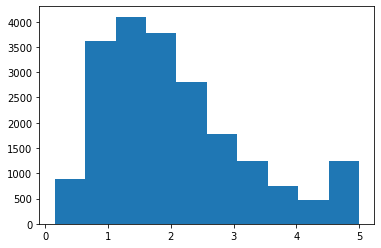

In [3]:
# histograma target (precios)
plt.hist(housing['target'])
plt.show()

### 2. Generar funciones para entrenar diferentes modelos individuales y evaluarlos

In [4]:
def train_model(model, X, y):
    """
    Entrenar modelo
    """
    model.fit(X, y)
    return model

In [5]:
def evaluate_metrics(model, X, y_true, info = False):
    """
    Evaluate rmse, mae, mean of rmse+mae.
    
    OBS: 
     - Inside the functions is called the method model.predict()
     - Calculate the metrics (using y_true vs y_predict) and save it in a dataframe
    """
    # predict
    prediction = model.predict(X)
    
    # create a dataframe where the metrics are saved
    df_metrics = pd.DataFrame([], columns = ['metric_value'])
    
    
    #### rmse ####
    # calculate
    rmse = mean_squared_error(y_true = y_true,
                  y_pred = prediction,
                  squared = False)
    # save df
    df_metrics = df_metrics.append(pd.DataFrame([rmse], index = ['RMSE'], columns = ['metric_value']))
    
    
    
    #### mae ####
    # calculate
    mae = mean_absolute_error(y_true = y_true,
                         y_pred = prediction)
    
    # save df
    df_metrics = df_metrics.append(pd.DataFrame([mae], index = ['MAE'], columns = ['metric_value']))
    
    
    
    #### (rmse + mae) / 2 ####
    # calculate
    rmse_mae = (rmse + mae) / 2
    
    # save df
    df_metrics = df_metrics.append(pd.DataFrame([rmse_mae], index = ['RMSE_MAE'], columns = ['metric_value']))
    
    
    
    #### PRINT INFO ####
    if info:
        print('RMSE: ', rmse)
        print('MAE: ', mae)
        print('MEAN_RMSE_MAE: ', rmse_mae)
    
    
    return df_metrics

### 3. Entrenar y Evaluar Regresión Lineal

In [6]:
model_lr = LinearRegression()

In [7]:
# train
train_model(model = model_lr, 
            X = X_train, 
            y = y_train
           )

LinearRegression()

In [8]:
# evaluar
df_metrics_lr = evaluate_metrics(model = model_lr, 
                                 X = X_test, 
                                 y_true = y_test
                                )

df_metrics_lr

,metric_value
RMSE,0.745581
MAE,0.533200
RMSE_MAE,0.639391


### 4. Entrenar Random Forest

In [9]:
model_rf = RandomForestRegressor(5, random_state = 42)

In [10]:
# train
train_model(model = model_rf, 
            X = X_train, 
            y = y_train
           )

RandomForestRegressor(n_estimators=5, random_state=42)

In [11]:
# evaluar
df_metrics_rf = evaluate_metrics(model = model_rf, 
                                 X = X_test, 
                                 y_true = y_test
                                )

df_metrics_rf

,metric_value
RMSE,0.552773
MAE,0.364361
RMSE_MAE,0.458567


### 5. Entrenar XGB

In [12]:
from xgboost import XGBRegressor

In [13]:
model_xgb = XGBRegressor(random_state = 42, objective = "reg:squarederror")

In [14]:
# train
train_model(model = model_xgb, 
            X = X_train, 
            y = y_train
           )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [15]:
# evaluar
df_metrics_xgb = evaluate_metrics(model = model_xgb, 
                                 X = X_test, 
                                 y_true = y_test
                                )

df_metrics_xgb

,metric_value
RMSE,0.473902
MAE,0.311302
RMSE_MAE,0.392602


### 6. Stacking models

In [16]:
def stacking():
    # define the base models level.append(('name_model', model))
    level0 = []
    
    level0.append(
        ('lr', LinearRegression())
    )
    
    level0.append(
        ('rf', RandomForestRegressor(100, random_state = 42))
    )
    
    level0.append(
        ('xgb', XGBRegressor(random_state = 42, objective = "reg:squarederror"))
    )
    
    
    # define meta learner model
    level1 = LinearRegression()
    
    
    # define the stacking ensemble
    model = StackingRegressor(estimators = level0, final_estimator = level1, cv=5)
    
    return model

In [17]:
model_stacking = stacking()

In [18]:
# train
train_model(model = model_stacking, 
            X = X_train, 
            y = y_train
           )

StackingRegressor(cv=5,
                  estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, g...
                                            importance_type=None,
                                            interaction_c

In [19]:
# evaluar
df_metrics_stacking = evaluate_metrics(model = model_stacking, 
                                 X = X_test, 
                                 y_true = y_test
                                )

df_metrics_stacking

,metric_value
RMSE,0.469241
MAE,0.304173
RMSE_MAE,0.386707


### Comparar resultados. Métrica RMSE
Se puede observar que bajo la métrica RMSE en los datos de test se obtienen los mejores valores de métricas utilizando el modelo stacking

In [20]:
output = pd.DataFrame(columns = ['lr', 'rf', 'xgb', 'stacking'])

output['lr'] = [np.round(df_metrics_lr.T['RMSE'].values[0], 4)]
output['rf'] = [np.round(df_metrics_rf.T['RMSE'].values[0], 4)]
output['xgb'] = [np.round(df_metrics_xgb.T['RMSE'].values[0], 4)]
output['stacking'] = [np.round(df_metrics_stacking.T['RMSE'].values[0], 4)]

output

,lr,rf,xgb,stacking
0,0.7456,0.5528,0.4739,0.4692


### 7.1. Guardar pkl mejor modelo

In [21]:
# guardar pickle modelo
import pickle

model_name = 'model.pkl'
with open(model_name, 'wb') as file:
    pickle.dump(model_stacking, file)

### 7.2 Cargar modelo guardado

In [22]:
import pandas as pd
model_name = 'model.pkl'
model = pd.read_pickle(model_name)